<div class="licence">
<span><img src="media/logo_IPParis.png" /></span>
<span>Lisa BEDIN<br />Pierre André CORNILLON<br />Eric MATZNER-LOBER</span>
<span>Licence CC BY-NC-ND</span>
</div>

# Modules

Importer les modules pandas (comme `pd`) numpy (commme `np`) le sous module `pyplot` de `matplotlib` comme `plt` les fonctions `StandardScaler` de `sklearn.preprocessing`, `Lasso` de `sklearn.linear_model`, `LassoCV` de `sklearn.linear_model`, `ElasticNet` de `sklearn.linear_model`, `ElasticNetCV` de `sklearn.linear_model`, `cross_val_predict` de `sklearn.model_selection`, `KFold` de `sklearn.model_selection`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

# Régression lasso sur les données d'ozone


## Importation des données

Importer les données d'ozone `ozonecomplet.csv` et éliminer les deux dernières variables (qualitatives) et faites un résumé numérique par variable [méthode `astype` sur la colonne du DataFrame et méthode `describe` sur l'instance DataFrame\]

In [2]:
ozone = pd.read_csv("data/ozonecomplet.csv", header=0, sep=";")
ozone = ozone.drop(['nomligne', 'Ne', 'Dv'], axis=1)
ozone.describe()

,O3,T9,T12,T15,Ne9,Ne12,Ne15,Vx9,Vx12,Vx15,O3v
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,90.303571,18.360714,21.526786,22.627679,4.928571,5.017857,4.830357,-1.214346,-1.611004,-1.690683,90.571429
std,28.187225,3.122726,4.042321,4.530859,2.594916,2.281860,2.332259,2.632742,2.795673,2.810198,28.276853
min,42.000000,11.300000,14.000000,14.900000,0.000000,0.000000,0.000000,-7.878500,-7.878500,-9.000000,42.000000
25%,70.750000,16.200000,18.600000,19.275000,3.000000,4.000000,3.000000,-3.276450,-3.564700,-3.939200,71.000000
50%,81.500000,17.800000,20.550000,22.050000,6.000000,5.000000,5.000000,-0.866000,-1.879400,-1.549650,82.500000
75%,106.000000,19.925000,23.550000,25.400000,7.000000,7.000000,7.000000,0.694600,0.000000,0.000000,106.000000
max,166.000000,27.000000,33.500000,35.500000,8.000000,8.000000,8.000000,5.196200,6.577800,5.000000,166.000000


## Création des tableaux `numpy`

avec l'aide des méthodes d'instance `iloc` ou `loc` créer les tableaux `numpy` `y` et `X` (on se servira de l'attribut `values` qui donne le tableau `numpy` sous-jascent)

In [3]:
y = ozone.O3.values
X = ozone.iloc[:,1:].values

## Centrage et réduction

Centrer et réduire les variable avec `StandardScaler` selon le schéma suivant

1.  créer une instance avec la fonction `StandardScaler`. On notera `scalerX` l'instance créée.
2.  l'ajuster via la méthode d'instance `fit` (calcul des moyennes et écart-types) et avec le tableau `numpy` des $X$
3.  Transformer le tableau $X$ en tableau centré réduit via la méthode d'instance `transform` et avec le tableau `numpy` des $X$.

In [4]:
scalerX = StandardScaler().fit(X)
Xcr= scalerX.transform(X)

## Evolution des coefficients selon $\lambda$

La fonction `LassoCV` va donner directement la grille de $\lambda$ (contrairement à ridge). Utiliser cette fonction sur les données centrées réduites pour récupérer la grille (attribut `alphas_`). Avec cette grille faire un boucle pour estimer les coefficients $\hat\beta(\lambda)$ pour chaque valeur de $\lambda$

Ajustons le modèle pour chaque valeur de $\lambda$:

In [5]:
rl = LassoCV().fit(Xcr,y)
alphas_lasso = rl.alphas_
lcoef = []
for ll in alphas_lasso:
    rl = Lasso(alpha=ll).fit(Xcr,y)
    lcoef.append(rl.coef_)

et traçons les coefficients:

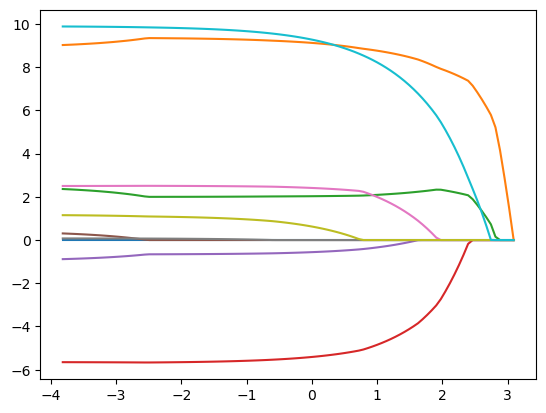

In [6]:
plt.plot(np.log(alphas_lasso), lcoef)
plt.show()

On voit que pour une certaine valeur de $\lambda$ (ici 22) tous les coefficients sont nuls.


## Choix du $\hat \lambda$ optimal (par validation croisée 10 blocs/fold)

En séparant le jeu de données en 10 Blocs grâce à la fonction [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) (l'instance de `KFold` sera nommée `kf`) trouver le $\hat \lambda$ optimal avec un score "somme des erreurs quadratiques par bloc" ; utiliser `cross_val_predict` (la grille devra être fournie à `Lasso`)

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
res = pd.DataFrame(np.zeros((X.shape[0], len(alphas_lasso))))
for j, ll in enumerate(alphas_lasso):
    res.iloc[:,j] = cross_val_predict(Lasso(alpha=ll),Xcr,y,cv=kf)
sse = res.apply(lambda x: ((x-y)**2).sum(), axis=0)
print(alphas_lasso[sse.argmin()])

0.7727174033372731


## Retrouver les résultats de la question précédente

Avec la fonction `LassoCV` et l'objet `kf` retrouver le $\hat \lambda$ optimal (par validation croisée 10 blocs/fold)

In [8]:
rl = LassoCV(cv=kf).fit(Xcr, y)
print(rl.alpha_)

0.7727174033372731


    0.7727174033372736

Ici la fonction objectif est le $\mathrm{R}^2$ par bloc (et pas la somme des écarts quadratiques) et on retrouve le même $\hat \lambda$ (ce qui n'est pas garanti dans tous les cas…)


## Prévision

Utiliser la régression ridge avec $\hat \lambda$ optimal pour prévoir la concentration d'ozone pour $x^*=(18, 18, 18 ,5 ,5 , 6, 5 ,-4 ,-3, 90)'$

In [9]:
xet = np.array([[18, 18, 18 ,5 ,5 , 6, 5 ,-4 ,-3, 90]])
xetcr = scalerX.transform(xet)
print(rl.predict(xetcr))

[85.28390512]


    [85.28390512]


# Elastic-Net

refaire avec les mêmes données les questions de l'exercice précédent avec une balance entre norme 1 et norme 2 de 1/2 (`l1_ratio`).


## Importation

In [10]:
ozone = pd.read_csv("data/ozonecomplet.csv", header=0, sep=";")
ozone = ozone.drop(['nomligne', 'Ne', 'Dv'], axis=1)
ozone.describe()

,O3,T9,T12,T15,Ne9,Ne12,Ne15,Vx9,Vx12,Vx15,O3v
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,90.303571,18.360714,21.526786,22.627679,4.928571,5.017857,4.830357,-1.214346,-1.611004,-1.690683,90.571429
std,28.187225,3.122726,4.042321,4.530859,2.594916,2.281860,2.332259,2.632742,2.795673,2.810198,28.276853
min,42.000000,11.300000,14.000000,14.900000,0.000000,0.000000,0.000000,-7.878500,-7.878500,-9.000000,42.000000
25%,70.750000,16.200000,18.600000,19.275000,3.000000,4.000000,3.000000,-3.276450,-3.564700,-3.939200,71.000000
50%,81.500000,17.800000,20.550000,22.050000,6.000000,5.000000,5.000000,-0.866000,-1.879400,-1.549650,82.500000
75%,106.000000,19.925000,23.550000,25.400000,7.000000,7.000000,7.000000,0.694600,0.000000,0.000000,106.000000
max,166.000000,27.000000,33.500000,35.500000,8.000000,8.000000,8.000000,5.196200,6.577800,5.000000,166.000000


## Création des tableaux `numpy`

avec l'aide des méthodes d'instance `iloc` ou `loc` créer les tableaux `numpy` `y` et `X` (on se servira de l'attribut `values` qui donne le tableau `numpy` sous-jascent)

In [11]:
y = ozone.O3.values
X = ozone.iloc[:,1:].values

## Centrage et réduction

In [12]:
scalerX = StandardScaler().fit(X)
Xcr= scalerX.transform(X)

## Evolution des coefficients selon $\lambda$

Ajustons le modèle pour chaque valeur de $\lambda$:

In [13]:
ren = ElasticNetCV().fit(Xcr,y)
alphas_elasticnet = ren.alphas_
lcoef = []
for ll in alphas_elasticnet:
    ren = ElasticNet(alpha=ll).fit(Xcr,y)
    lcoef.append(ren.coef_)

et traçons les coefficients:

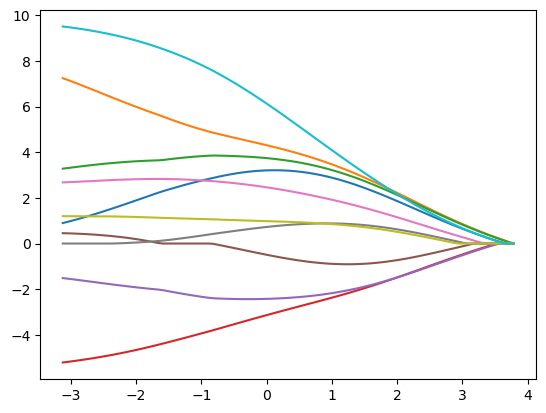

In [14]:
plt.plot(np.log(alphas_elasticnet), lcoef)
plt.show()

On voit que les coefficients en général décroissent (en valeur absolue) quand la pénalité augmente.


## Choix du $\hat \lambda$ optimal (par validation croisée 10 blocs/fold)

In [15]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
res = pd.DataFrame(np.zeros((X.shape[0], len(alphas_elasticnet))))
for j, ll in enumerate(alphas_elasticnet):
    res.iloc[:,j] = cross_val_predict(ElasticNet(alpha=ll),Xcr,y,cv=kf)
sse = res.apply(lambda x: ((x-y)**2).sum(), axis=0)
print(alphas_elasticnet[sse.argmin()])

0.41048105093488374


## Retrouver les résultats de la question précédente

Avec la fonction `ElasticNetCV` et l'objet `kf` retrouver le $\hat \lambda$ optimal (par validation croisée 10 blocs/fold)

In [16]:
ren = ElasticNetCV(cv=kf).fit(Xcr, y)
print(ren.alpha_)

0.41048105093488374


    0.41048105093488396

Ici la fonction objectif est le $\mathrm{R}^2$ par bloc (et pas la somme des écarts quadratiques) et on retrouve le même $\hat \lambda$ (ce qui n'est pas garanti dans tous les cas…)


## Prévision

Utiliser la régression ridge avec $\hat \lambda$ optimal pour prévoir la concentration d'ozone pour $x^*=(18, 18, 18 ,5 ,5 , 6, 5 ,-4 ,-3, 90)'$

In [17]:
xet = np.array([[18, 18, 18 ,5 ,5 , 6, 5 ,-4 ,-3, 90]])
xetcr = scalerX.transform(xet)
print(ren.predict(xetcr))

[87.15292087]


    [87.15292087]

Pas le même modèle ici donc pas la même prévision.